<a href="https://colab.research.google.com/github/ErgoProxy1/Learning_AI/blob/main/micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 1 Graphs and gradients

In [598]:
# https://www.youtube.com/watch?v=VMj-3S1tku0&list=WL&index=35&t=536s
# https://github.com/karpathy/micrograd

In [599]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [600]:
# quadratic function f(x) = 3x^2 - 4x + 5
def f(x):
    return 3*x**2 - 4*x + 5

In [601]:
f(3.0)

20.0

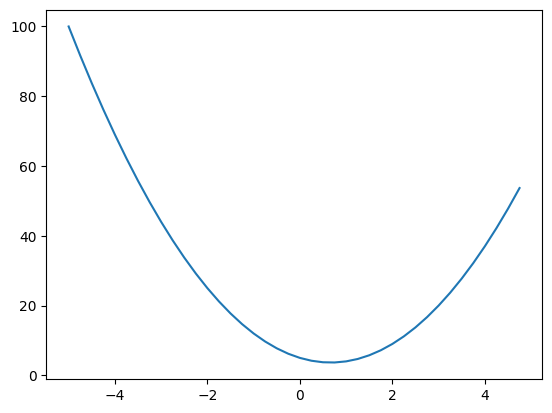

In [602]:
xs = np.arange(-5, 5, 0.25) #numpy array
plt.plot(xs, f(xs)) # plot f(x) given xs are the possible values of x (therefore f(xs) gives us the y values)

Remember the definition of a derivative (assume a is x here). The derivative describes how x reacts to small changes of size h, aka how the slope of the tangent changes. So the derivative gives us an equation which indicates how the slope of the tangent for a given x changes as x changes.

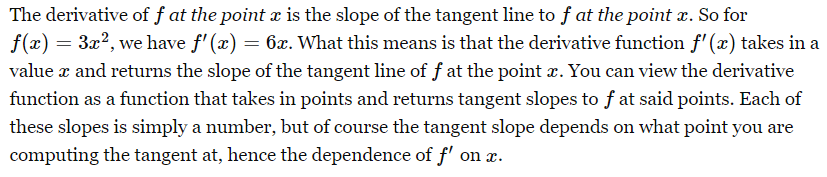

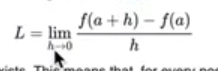

In [603]:
h = 0.001 #given a very small h aka tends to 0
x = 3.0
y1 = f(x)
print(y1)
y2 = f(x+h) # y2 being greater than y1 shows that f(x) increases positively as x increases positively by h for this given value of x
print(y2)
slope = (y2-y1)/h # This is the approximated slope of the tangent at given point x. y2-y1 simply tells us by how much y has changed, and h is by how much x has changed.
print(slope)

20.0
20.014003000000002
14.00300000000243


In [604]:
#For demos sake, at the negative value of x, when increased by h, it is actual y1 that becomes greater than y2. This makes sense as the slope of the tangent would still be negative in this case
print(f(-x))
print(f(-x+h))
print((f(-x+h) - f(-x))/h)

#At x = 2/3 y2 and y1 would be equal since the slope would be 0. This makes sense considering f'(x) = 6x - 4, so 6*2/3 - 4 = 0

44.0
43.978003
-21.996999999998934


In [605]:
# lets get more complexe he says
a = 2.0
b = -3.0
c = 10.0
d = a*b + c # d is a function of 3 scalare inputs, 3 variables
print(d)

4.0


In [606]:
# Now how can we evaluate the derivative of d with respect to a,b,c
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

#function
d1 = a*b + c

a += h # Lets then increment a by h to help us later find the slope with resoect to a
d2 = a*b + c # Shows us the effect of in an increase of a by h on our value

print('d1', d1)
print('d2', d2)

slope_a = (d2-d1)/h
print('slope_a', slope_a) # slope with respect to change in a by h

# We can see that increasing a made d2 smaller than d1, and this is expected since b is negative. This then lets us know that the slope of the tangent with respect to a will be negative at a = 2.0
# Also the derivate of d = a*b + c with respect to a is d' = b. So as b = -3.0, we can intuitively tell that the slope of the tangent will be -3.0 as well.

d1 4.0
d2 3.999699999999999
slope_a -3.000000000010772


In [607]:
# And if we do the same thing for b and c
a = 2.0
b = -3.0
c = 10.0

b += h
d3 = a*b + c

print('d1', d1)
print('d3', d3)

slope_b = (d3-d1)/h
print('slope_b', slope_b) # Will be 2 since d' = a

a = 2.0
b = -3.0
c = 10.0

c += h
d4 = a*b + c

print('d1', d1)
print('d4', d4)

slope_c = (d4-d1)/h
print('slope_c', slope_c) # will be 1 since d' = 1 (as c is the only variable when deriving with respect to it, so it simply becomes 1)

d1 4.0
d3 4.0002
slope_b 2.0000000000042206
d1 4.0
d4 4.0001
slope_c 0.9999999999976694


In [608]:
# Now that we have a more intuitive understanding of derivatives, we can apply this concept to basic neural networks. We're using micrograd as an example,
# which gives us a Value object that allows to do operations on values and then backpropagate to the previous state

class Value:
    def __init__(self, data):
        self.data = data
    def __repr__(self):
      return f"Value(data={self.data})"

a = Value(2.0)
a

Value(data=2.0)

In [609]:
# Now lets give our class the ability to add,mul,sub,div values together
# Use __add__, __mul__, __sub__, and __truediv__
class Value:
    def __init__(self, data):
        self.data = data
    def __repr__(self):
      return f"Value(data={self.data})"
    def __add__(self, other):
        out = Value(self.data + other.data)
        return out
    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out
    def __sub__(self, other):
        out = Value(self.data - other.data)
        return out
    def __truediv__(self, other):
        out = Value(self.data / other.data)
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
print(a + b)
print(a * b)
print(a - b)
print(a / b)
print(a*b + c) #(a.__mul__(b)).__add__(c)

Value(data=-1.0)
Value(data=-6.0)
Value(data=5.0)
Value(data=-0.6666666666666666)
Value(data=4.0)


In [610]:
# Okay cool, we can now wrap values and operate on them. Now, lets add some a way to keep track of which operations created which values. AKA, create a graph of values and the operations that created them.
# Add a tuple of children
class Value:
    def __init__(self, data, _children=(), _op='', label=''): #new
        self.data = data
        self.grad = 0.0 # new, will use later
        self._prev = _children # new, note that the guy made it a set for efficiency but I dont care
        self._op = _op # new
        self.label = label # new
    def __repr__(self):
      return f"Value(data={self.data})"
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') #new, we are now incidcating that the new Value object had self and other as its previous values
        out.label = self.label + other.label
        return out
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*') #new, we are now incidcating that the new Value object had self and other as its previous values
        out.label = self.label + other.label
        return out
    def __sub__(self, other):
        out = Value(self.data - other.data, (self, other), '-') #new, we are now incidcating that the new Value object had self and other as its previous values
        out.label = self.label + other.label
        return out
    def __truediv__(self, other):
        out = Value(self.data / other.data, (self, other), '/') #new, we are now incidcating that the new Value object had self and other as its previous values
        out.label = self.label + other.label
        return out

a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
d = (a * b) + c
d.label= "d"
print(d, d._op, "| So d is the result of the additon of:")
print(d._prev, "| Aka a*b and c, and if we look at the first value:")
print(d._prev[0], d._prev[0]._op, "| So this is the result of the multiplication of:")
print(d._prev[0]._prev, "| Aka a and b")

Value(data=4.0) + | So d is the result of the additon of:
(Value(data=-6.0), Value(data=10.0)) | Aka a*b and c, and if we look at the first value:
Value(data=-6.0) * | So this is the result of the multiplication of:
(Value(data=2.0), Value(data=-3.0)) | Aka a and b


In [611]:
# Now we need to visualize all this
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR - left to right
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{l:s} | {d:.4f} | grad {g:.4f}".format(l=n.label, d=n.data, g=n.grad), shape='record') # new
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

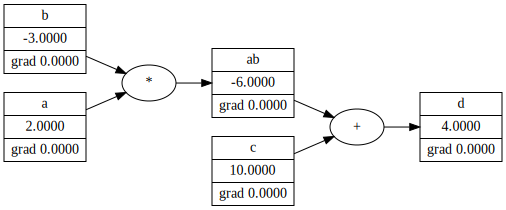

In [612]:
draw_dot(d)

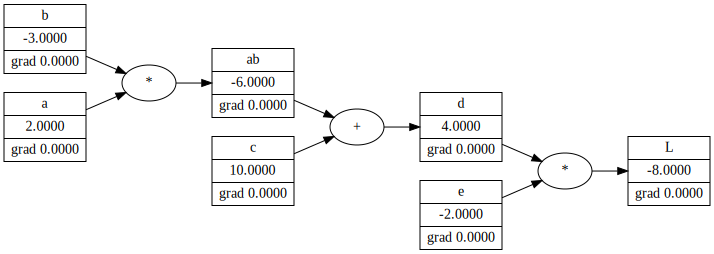

In [613]:
e = Value(-2.0, label='e')
L = d * e
L.label = 'L'
draw_dot(L)

So now when we backpropagate starting from L, what we're really going to do is go backwards by calculating the gradient, aka the vector of all the partial derivatives of L. But we're going to use gradient to refer to a derivative of L with respect to a specific value (a,b,c,etc.)

So we're first going to derive L with respect to L, which is 1, then L with respecect to f, then d, then c, then ab, then b, then a.

We can imagine that, in the context of a neural network, we have our Loss function (L here) for which we would be very interested in finding the gradient with respect to our neural network nodes. We can then have an idea of how changing the value of a given node affects the outcome, aka the Loss here, which can then allow us to run optimizations by updating the weights of our nodes.

***THE GRADIENT OF A NODE INDICATES HOW MUCH THE LOSS FUNCTION CHANGES IF WE WERE TO ADJUST THE VALUE OF SAID NODE.***

A grad of 0 represents NO effect

Below, we're going to track the gradient of each node, aka the derivative of L with respect to the current value.

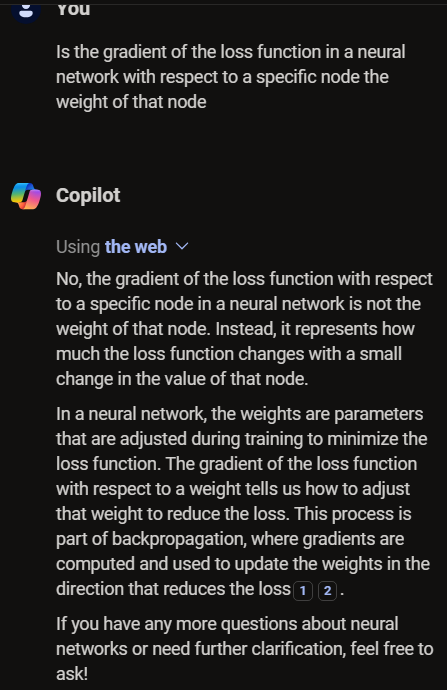

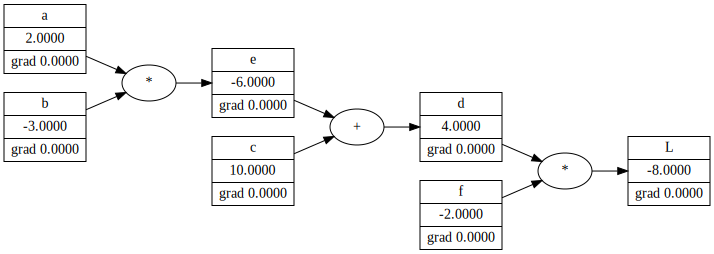

In [614]:
# So lets add a way to track the gradient of our current node
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b
e.label = 'e'
d = e + c
d.label= "d"
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
draw_dot(L)

In [615]:
# Now lets manually fill our gradient info

# For example, this will give us the derivative of L with respect to whichever one we bump by h (Im just changing this manually, just to let me check my values)
def lol():
  h = 0.0001

  a = Value(2.0, label="a")
  b = Value(-3.0, label="b")
  c = Value(10.0, label="c")
  e = a*b
  e.label = 'e'
  d = e + c
  d.label= "d"
  f = Value(-2.0, label='f')
  L = d * f
  L.label = 'L'
  #new
  L1 = L.data

  a = Value(2.0-h, label="a") # new
  b = Value(-3.0, label="b")
  c = Value(10.0, label="c")
  e = a*b
  e.label = 'e'
  d = e + c
  d.label= "d"
  f = Value(-2.0, label='f')
  L = d * f
  L.label = 'L'
  #new
  L2 = L.data

  print((L2 - L1)/h)

lol()

-6.00000000000378


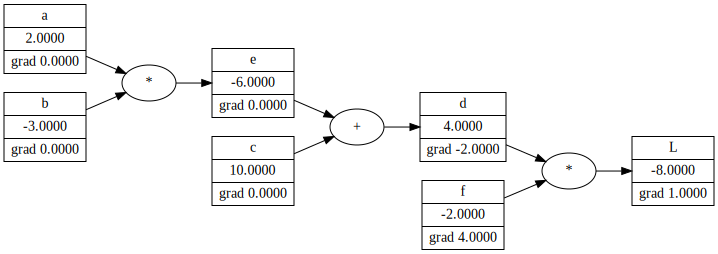

In [616]:
# So filling it out
L.grad = 1.0
# Since L = d * f, the derivative of L with respect to d is L' = f, and with respect to f is L' = d. Notice then that the grad of f is the value of d, and the grad of d is the value of f
d.grad = f.data # dL/dd
f.grad = d.data # dL/df
draw_dot(L)

Then when we get to c and e, we can use the chain rule because we know how  L affects d, and we know how c and e affect d.

as d = c + e

then

dd/dc = 1.0

dd/de = 1.0 (also because law of equivalence or something)

Note that this only represents the LOCAL derivative, not the actual full thing with respect to L. We simply now know how c and e affect d locally through the "+" node.

**The chain rule:**

**dz/dx = (dz/dy) * (dy/dx); where  z depends on y and y depends on xtext**

SO

dL/dc = (dL/dd) * (dd/dc) = -2.0 * 1.0 = -2.0

dL/de = (dL/dd) * (dd/de) = -2 * 1.0 = -2.0

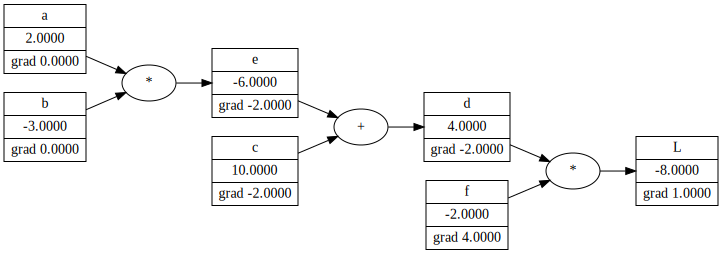

In [617]:
# Another way to look at it is since L = d * f, and d = c + e, then L = (c + e) * f. Then the derivative of L with respect to c is L' = f, and with respect to e is L' = f
c.grad = f.data
e.grad = f.data
draw_dot(L)

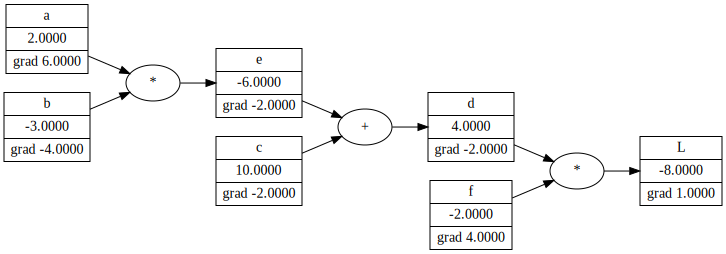

In [618]:
# And we can then use the chain rule again to get dL/da and dL/db
a.grad = e.grad * b.data # dL/da = (dL/de) * (da/de) and da/de = b
b.grad = e.grad * a.data # dL/da = (dL/de) * (db/de) and db/de = a
draw_dot(L)

***BACKPROPAGATION IS JUST THIS: THE RECURSIVE APPLICATION OF CHAIN RULE TO FIND DERIVATIVES WITH RESPECT TO THE ROOT***

And to show this in action, watch what happens in the code below we when update our leaf nodes by a small factor, aka by nudging the values towards the gradient.

The value went up, since we're moving all our inputs in the direction of the gradient. This is one step of an optimization of a neural network.

In [619]:
# Update
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

#forwardpass
e = a * b
d = e + c
L = d * f
print(L.data)


-7.286496


## Part 2 Neurons

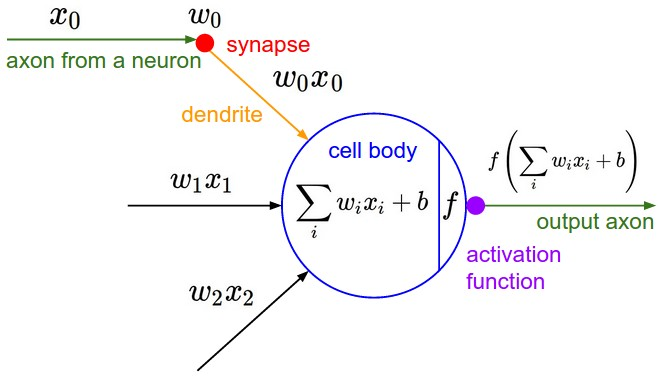

Here, x represents input to the neuron, w represents the weight of the input, the b represents a bias hyperparam (triggerhappiness), f represents an activation function (such as ReLU, sigmoid, tanh, etc.) which transforms (squashes) the calculated value within the neuron, and outputs a new value to be used by other neurons

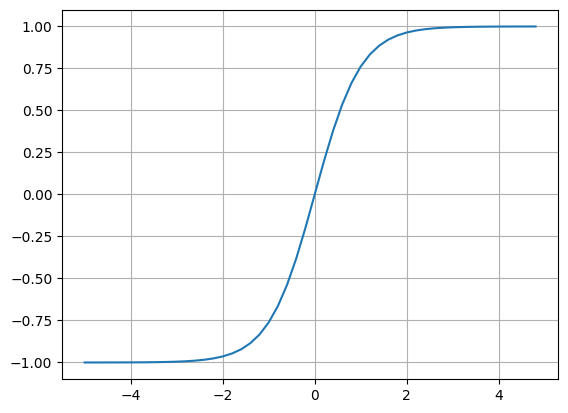

In [620]:
# For reference, here is an example of a tanh function. Is 0 at 0, but caps out at 1 and -1.

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [621]:
# First we're going to need to expand our Value object to be able to implement tanh
class Value:
    def __init__(self, data, _children=(), _op='', label=''): #new
        self.data = data
        self.grad = 0.0 # new, will use later
        self._prev = _children # new, note that the guy made it a set for efficiency but I dont care
        self._op = _op # new
        self.label = label # new
    def __repr__(self):
      return f"Value(data={self.data})"
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') #new, we are now incidcating that the new Value object had self and other as its previous values
        out.label = self.label + other.label
        return out
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*') #new, we are now incidcating that the new Value object had self and other as its previous values
        out.label = self.label + other.label
        return out
    def __sub__(self, other):
        out = Value(self.data - other.data, (self, other), '-') #new, we are now incidcating that the new Value object had self and other as its previous values
        out.label = self.label + other.label
        return out
    def __truediv__(self, other):
        out = Value(self.data / other.data, (self, other), '/') #new, we are now incidcating that the new Value object had self and other as its previous values
        out.label = self.label + other.label
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out

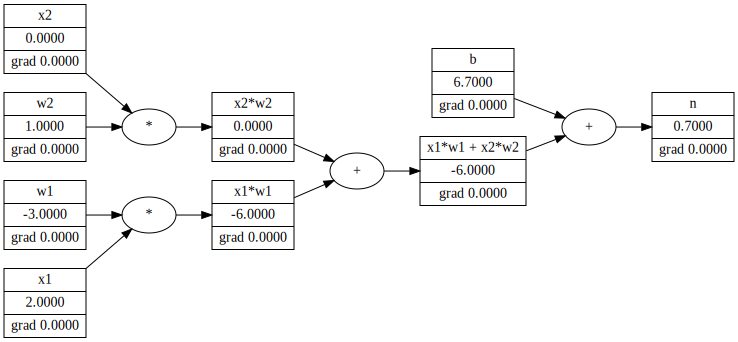

In [622]:
# So writing this out as a 2 dimentional neuron
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neurons
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.7, label='b')

# n = x1*w1 + x2*w2 + b (n being the raw cell body data aka not activated)
x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'

draw_dot(n) #So this whole graph represents a neuron before the activation function (inputs, weights, summation of product, bias)

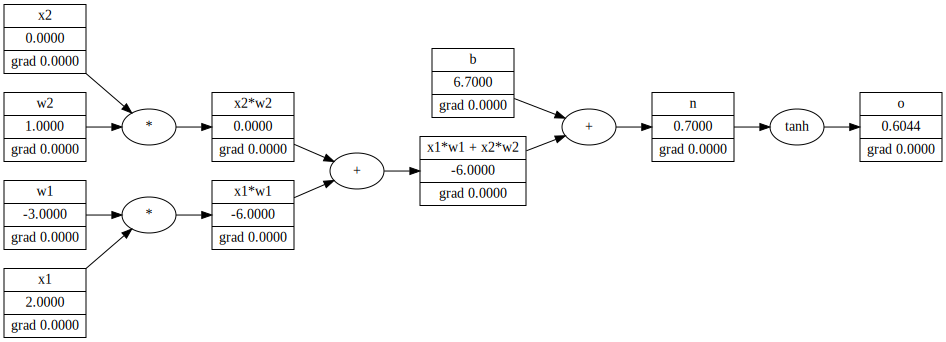

In [623]:
# And when we apply tanh
o = n.tanh()
o.label = 'o'
draw_dot(o) # We now also have our activation function and output defined

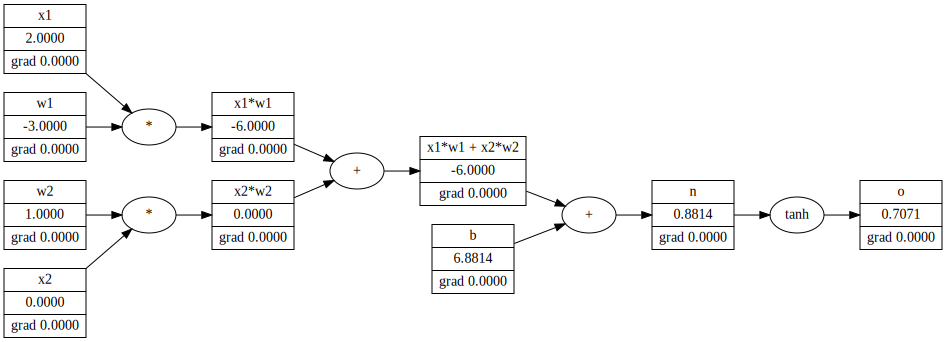

In [624]:
# Now watch what happens when we increase our bias, we will get closer to the tail end of the tanh function (closer to 1)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b') # new

x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'o'
draw_dot(o)

Now that our neuron was calculated, we can go ahead and backtrack to calculate our gradients

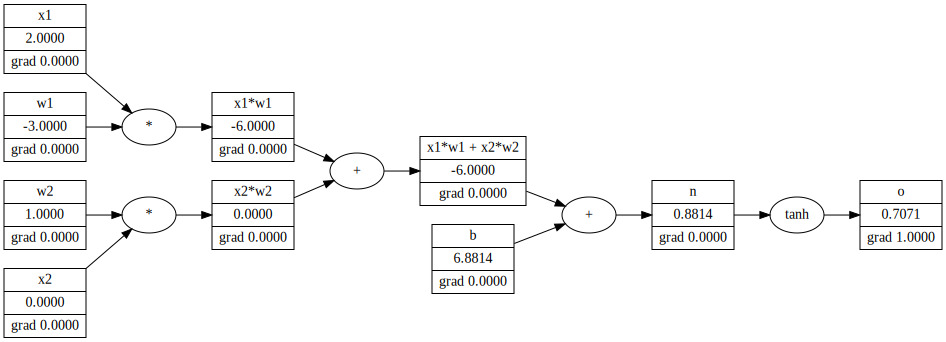

In [625]:
o.grad = 1 # We know this since the do/do = 1
draw_dot(o)

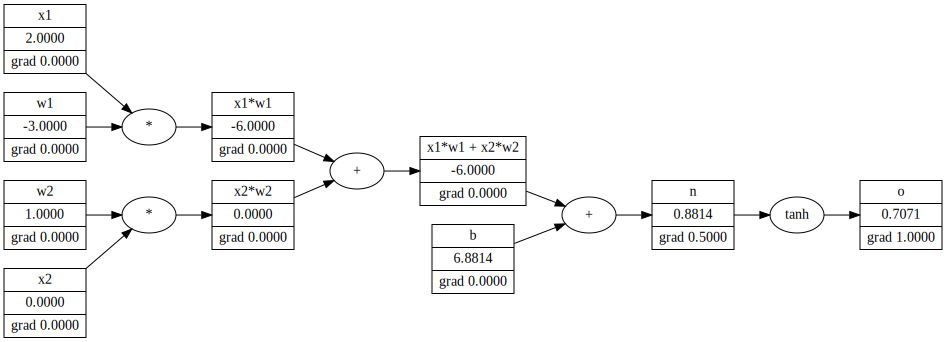

In [626]:
# Now n, where o = tanh(n). We therefore know that do/dn = 1 - tanh(n)^2 (You can check this by googling the derivative of tanh)
# Aka do/dn = 1 - o^2
n.grad = 1 - o.data**2
draw_dot(o)

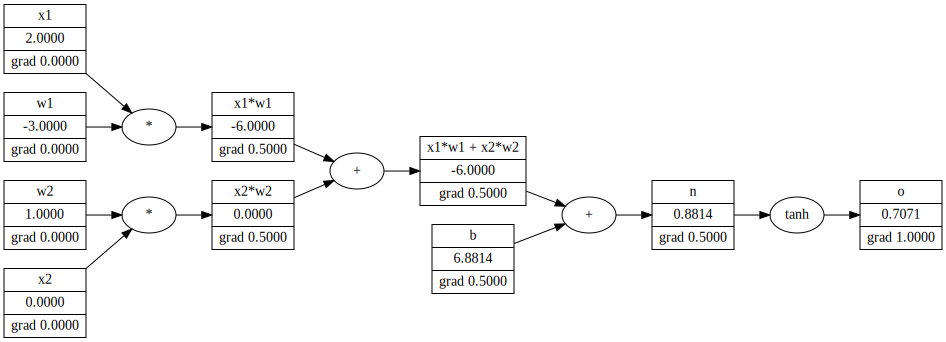

In [627]:
# Now x1w1x2w2 and b, and x1w1 and x2w2, and due to chain rule:
x1w1x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = n.grad
x2w2.grad = n.grad
draw_dot(o)

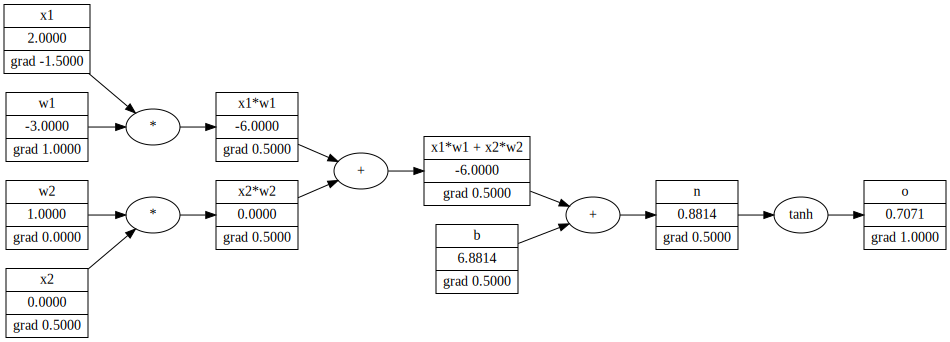

In [628]:
# Now x1, w1, x2, and w2, and remembering the chain rule:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
draw_dot(o) # Remember intuitively for w2, the reason the grad = 0 is to show that changing it has no effect on the outcome, since its multiplied by x1 which is 0.

We now have an intuitive understanding of neurons and the principal behind backpropagation, so lets now integrate it in code. Thanks to our understanding of backpropagation and the use of local gradients (through the chain rule), we can effectively create a method that enables us to recursively calculate our gradients starting from the root (which we know will be 1)

In [629]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # new, function that by default does nothing (example, leaf node)
        self._prev = _children
        self._op = _op
        self.label = label
    def __repr__(self):
      return f"Value(data={self.data})"
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward(): # new
          self.grad += 1.0 * out.grad # Note that we use += because the same node can depend no more than 1 node (multivariate case of chain rule)
          other.grad += 1.0 * out.grad

        out._backward = _backward #new

        out.label = self.label + other.label
        return out
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward(): # new
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad

        out._backward = _backward #new

        out.label = self.label + other.label

        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward(): #new
          self.grad += (1 - t**2) * out.grad

        out._backward = _backward #new

        return out

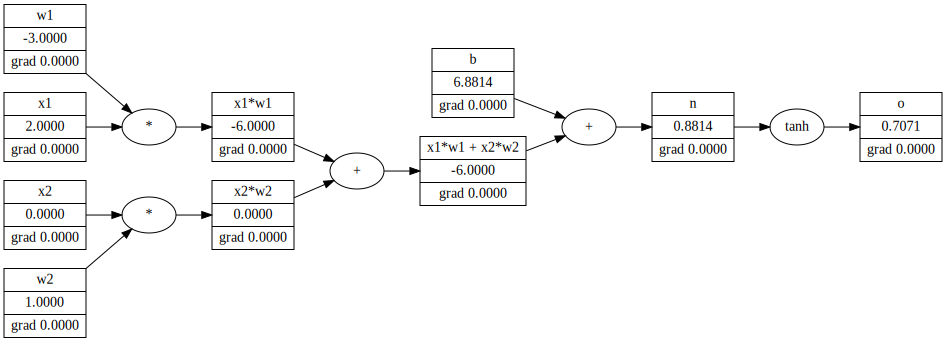

In [630]:
# So taking our previous values and graph
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b') # new

x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'o'
draw_dot(o)

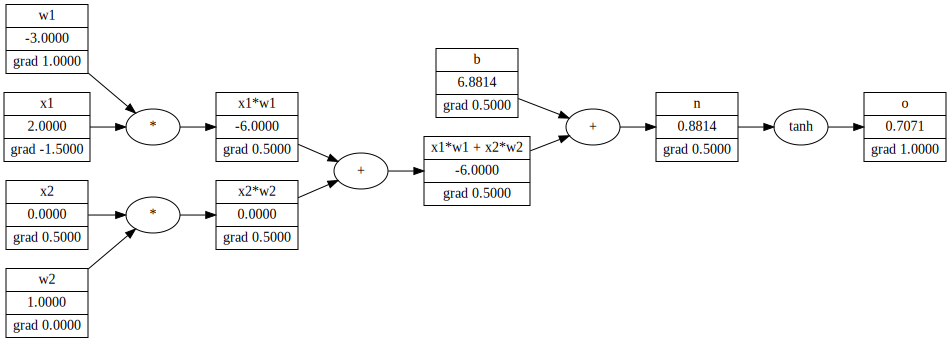

In [631]:
# We can now generate our backprop
o.grad = 1.0 # needed since grad is 0 by default
o._backward()
n._backward()
x1w1x2w2._backward()
b._backward() #does nothing since its a leaf
x1w1._backward()
x2w2._backward()
draw_dot(o)

topo list [Value(data=2.0), Value(data=-3.0), Value(data=-6.0), Value(data=0.0), Value(data=1.0), Value(data=0.0), Value(data=-6.0), Value(data=6.881373587019543), Value(data=0.8813735870195432), Value(data=0.7071067811865476)]


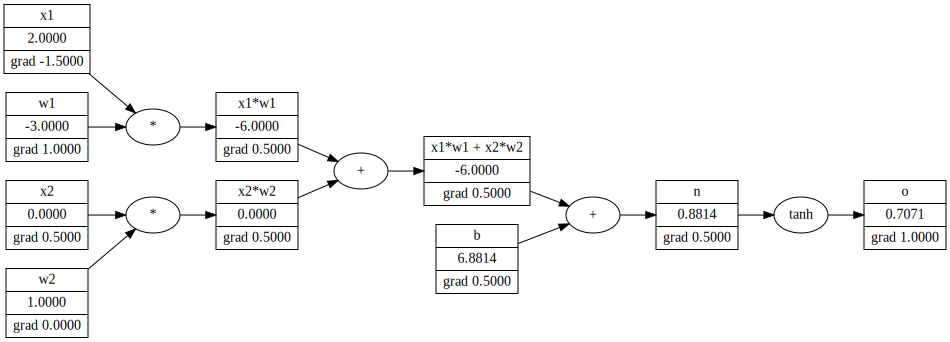

In [632]:
# And to automate this using topological sort
topo = []
visited = set()

def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b') # new

x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'o'
draw_dot(o)

o.grad = 1.0 # WE HAVE TO INIT
build_topo(o)
print("topo list", topo)

for node in reversed(topo):
  node._backward()
draw_dot(o)

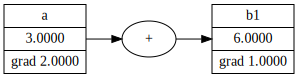

In [633]:
# Also to show the case for multivariate, we can see here that a1 will have a grad of 2, since db1 / da1 = 2 (because b = a + a)
a1 = Value(3.0, label='a')
b1 = a1 + a1
b1.label = 'b1'
b1.grad = 1.0
b1._backward()
draw_dot(b1)

And then of course we use forwardpass by updating our values using the gradient and seeing the effect on the output, aka the Loss were this the only neuron.

## Part 3 Pytorch

Now how can we do this using a library like Pytorch?

In [634]:
import torch

In [635]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True # Note that by default requires_grad is false because PyTorch assumes these are leaf nodes (inputs to neural network) which normally do not need gradients
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print('value of o', o.data.item())
o.backward()
print('grad of x1', x1.grad.item())
print('grad of x2', x2.grad.item())
print('grad of w1', w1.grad.item())
print('grad of w2', w2.grad.item())
# Can verify this is correct by looking at graph above

value of o 0.7071066904050358
grad of x1 -1.5000003851533106
grad of x2 0.5000001283844369
grad of w1 1.0000002567688737
grad of w2 0.0


Now that we've shown that we can sort of match what weve done manually before using PyTorch, let's go ahead and represent a neuron

We can then go ahead and represent a graph of neurons, aka a neural network

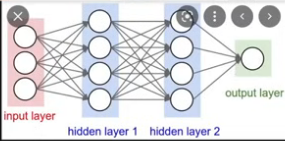

In [636]:
import random

class Value: # Expanded version of the Value object that supports scalars and additional operations

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [637]:
class Neuron:
  def __init__(self, nin): # nin = number of inputs
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # weights, notice its a list since we have multiple inputs into the neuron, each with a weight
    self.b = Value(random.uniform(-1,1)) # bias

  def __call__(self, x): # myObj(x), this is the forward pass in the beuron
    # E(w * x) + b
    activationInput = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # Zip takes two iterators and creates a new one which matches the corresponding positions into tuples
    output = activationInput.tanh()
    return output

  def parameters(self): #Convencience code, allows us to fetch the params easily the same as pytorch (so a list of the weights and the bias of the neuron)
    return self.w + [self.b]

class Layer: # Represents a layer of neurons
  def __init__(self, nin, nneur): # How many inputs does each neuron have, and how many are there
    self.neurons = [Neuron(nin) for _ in range(nneur)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()] # 1d continuous list of the parameters of the neurons in the layer

x = [2.0, 3.0]
n = Neuron(2)
print(n(x), "\n-------\n")

N = Layer(2,3)
N(x) # Three neurons in the layer

Value(data=-0.751419400393323) 
-------



[Value(data=-0.624693428359308),
 Value(data=0.8734538320333658),
 Value(data=-0.9956537868036467)]

In [638]:
# And now we can define a multi-layer preceptron aka a neural network
class MLP:
  def __init__(self, nin, layerSizes): #nin = number of inputs, and layerSizes is a list of ints, and each int represents how many neurons are in each given non-input layer, including the output layer
    size = [nin] + layerSizes #Size of our input layer as a list, then add it to the start of our layer list, which will be the total layers of the neural network
    self.layers = [Layer(size[i], size[i+1]) for i in range(len(layerSizes))]

  def __call__(self, x): # Call each layer sequentially, aka forward passing throughtout and entire MLP
    for layer in self.layers:
      x = layer(x) # each time we call a layer, we get a new x, aka the input to the next layer. Our final x will be the output
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()] # 1d continuous list of all the parameters in our neural net

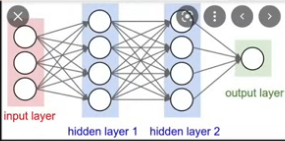

In [639]:
# So lets implement the above picture

input = [2.0, 3.0, -1.0]
NN = MLP(3, [4, 4, 1]) # 3 inputs in input layer, 4 in first hidden layer, 4 in second hidden layer, 1 in output layer
NN(input) # This passes the inputs, then each layer will be called sequentially, and within each layer each neuron will be calculated using the weights and activation function. What will be returned is the final value, the output

Value(data=-0.8972677113810456)

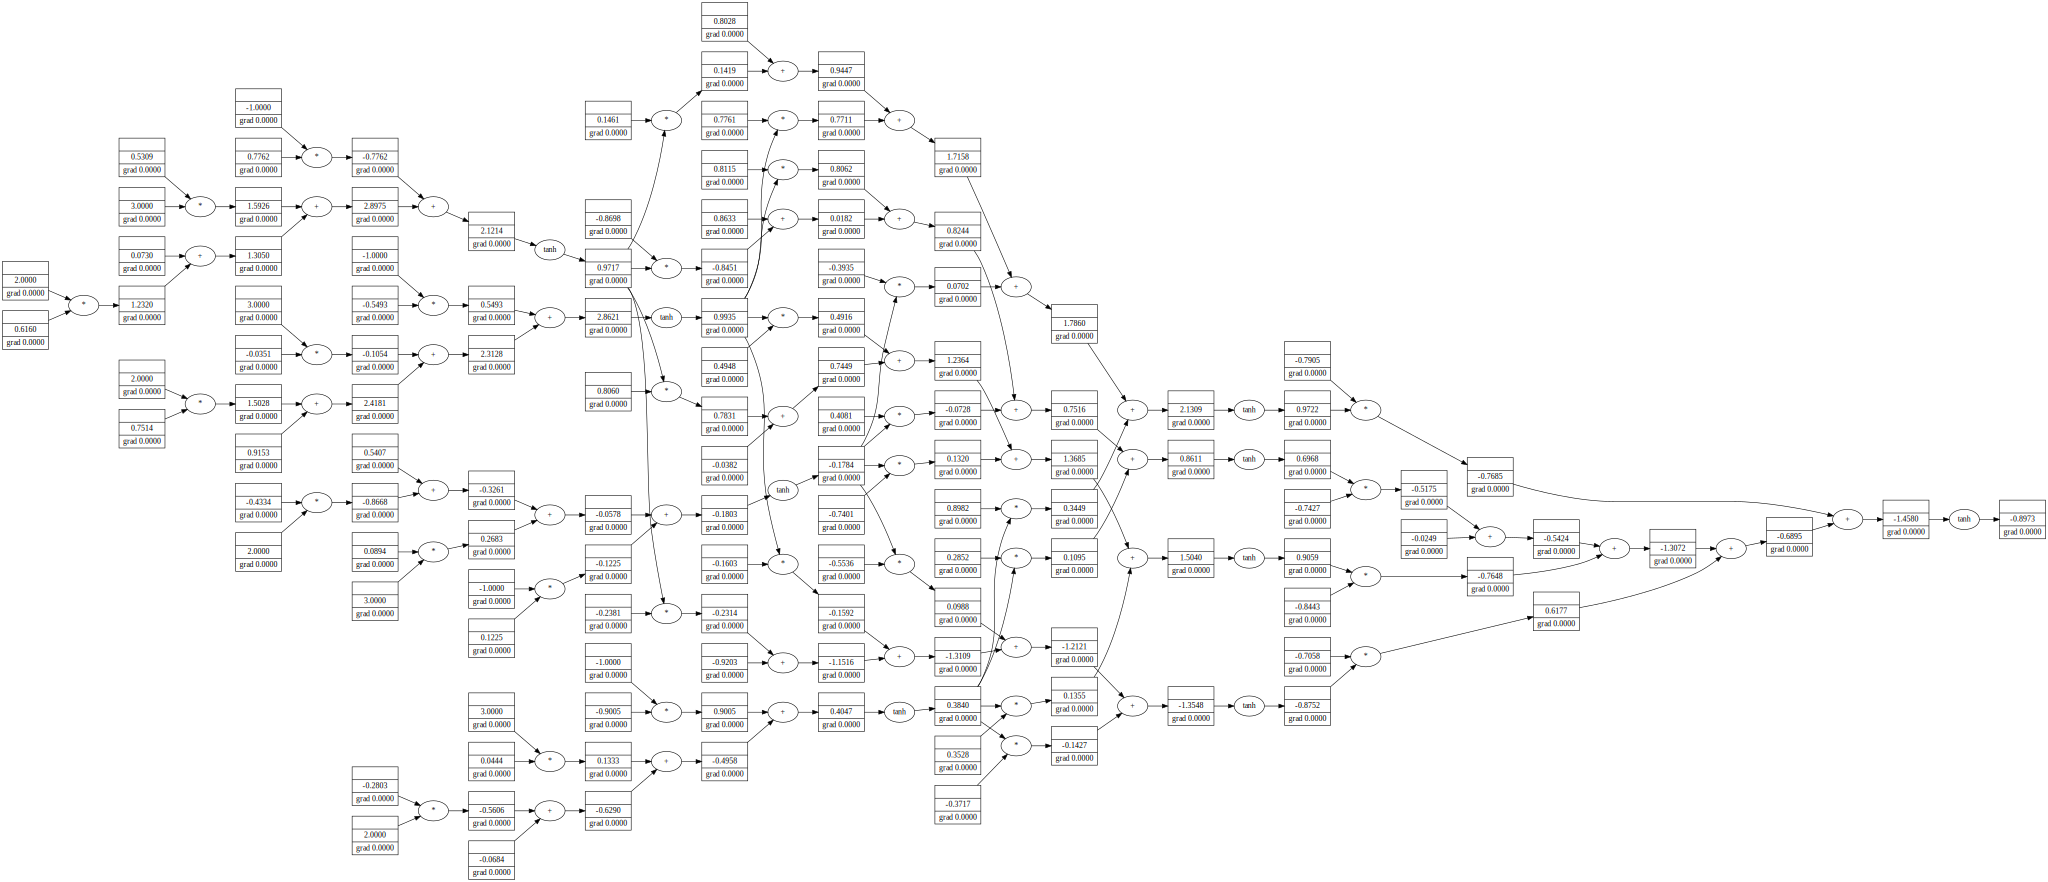

In [640]:
# We can print this out, and notice how we have 3 starting points and 1 output. It gets hard to follow bu the principal is there, this is a broken down representation of a basic neural network
# Notice also the 4 tanh before the final tanh, thats the second layer. And if you look in the middle, youll find that theres also 4 tanhs if you count them.
draw_dot(NN(input))

Now if you pay close attention, youll notice that the original inputs, and the outputs of that activation function (tanh) are always being multiplied by a number. This is the **weight**. Now what we can do is use backpropagation to calculate the gradients after each forwardpass, in order to constantly optimize our neural network.

In [641]:
# Example
xs = [ # List of 4 inputs, with each input having 3 vars
    [ 2.0 , 3.0 -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # 4 desired outputs
ypred = [NN(x) for x in xs]
ypred # Theyre incorrect for now

[Value(data=-0.8505414444730649),
 Value(data=-0.8547435143461126),
 Value(data=-0.432035598926514),
 Value(data=-0.8941974001899424)]

In [642]:
# How can measure the collective quality of our outputs when compared to the true targets? Using a Loss function!
loss = sum((y_out - y_truth)**2 for y_truth, y_out in zip(ys, ypred)) # Mean squared error Loss, which ensures a positive number that becomes 0 the closer it is to the truth
loss

Value(data=7.356170436110075)

In [643]:
# Now that we have a loss, we need to minimize it
loss.backward() # We do a backward pass, meaning all our nodes will now have gradien

In [644]:
NN.layers[0].neurons[0].w[0].grad # Meaning this now has a value (The grad of the weight of the first neuron in the first layer, aka the first input)
# If the grad is negative, it means increasing the weight will decrease the loss. If the grad is positive, it means increasing the weight will increase the loss (aka we should decrease it!). And this will change every time we backward pass.

0.09486973544722851

In [645]:
# draw_dot(loss) # This graph will be massive because it will include all 4 forward passes plus the calculation of all their losses plus the final loss

For example, if you uncomment the graph above, you'll notice something like this towards the end

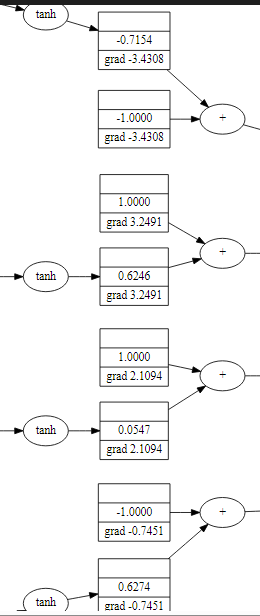

This represents the final output for all four of our predicitions (In this example, ypred is [Value(data=0.6274299041766198),
 Value(data=0.05471187188683822),
 Value(data=0.6245582907859427),
 Value(data=-0.7153963218268959)])

 And at the end we the calculation of the total loss. We can therefore use the loss to backpropagate our gradients and figure out how our weights should be adjusted.

 Another example, at the beginning we have this

 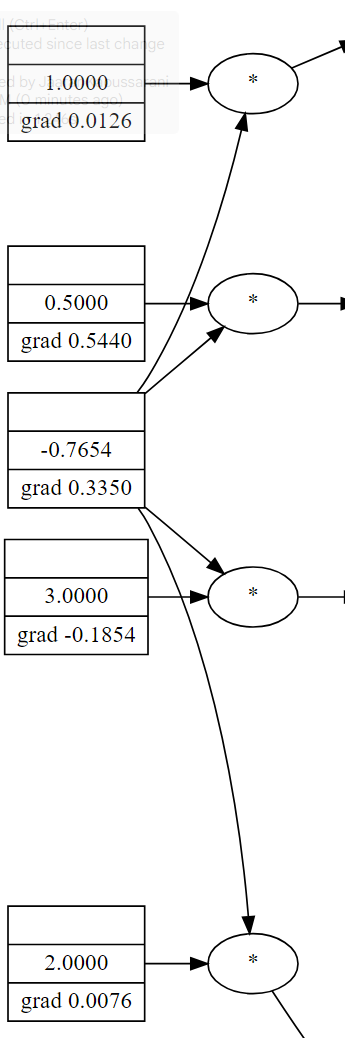

 And this corresponds to the first variable of all four of our inputs (x0), and we see the same weight being applied to all four plus a gradient. In other words, we now have a way of knowing how to adjust the weight of that variable input so as to minimize our loss.

In [646]:
# And this can be done since we have a list of of the parameters of the neural net
NN.parameters()

[Value(data=0.6159848821288083),
 Value(data=0.530850366606469),
 Value(data=0.7761777381428547),
 Value(data=0.07302045862527029),
 Value(data=0.7514029325709328),
 Value(data=-0.03511874077565302),
 Value(data=-0.5493394381309391),
 Value(data=0.9153099082364533),
 Value(data=-0.4334054689340783),
 Value(data=0.08941702450964706),
 Value(data=0.12248109744594715),
 Value(data=0.5407100170809642),
 Value(data=-0.28030143108205663),
 Value(data=0.04441884627038428),
 Value(data=-0.9004897769997957),
 Value(data=-0.06844496346284656),
 Value(data=-0.8697731598079717),
 Value(data=0.8115086576166726),
 Value(data=0.4080631997041273),
 Value(data=0.2851896770578992),
 Value(data=0.8633045329513227),
 Value(data=0.8059644990888357),
 Value(data=0.49477202513542307),
 Value(data=-0.7401451558015217),
 Value(data=0.35283333585251997),
 Value(data=-0.038249652507911236),
 Value(data=-0.23812346569726106),
 Value(data=-0.1602749591528836),
 Value(data=-0.5535752853285836),
 Value(data=-0.37171

In [647]:
NN.layers[0].neurons[0].w[0].grad

0.09486973544722851

In [648]:
NN.layers[0].neurons[0].w[0].data

0.6159848821288083

In [649]:
# So lets show an optimization!
for p in NN.parameters():
    p.data += -1 * 0.001 * p.grad # We modify our params by a tiny amount. Remember we need to make it negative too, since the gradient vector points in the direction of increasing loss, but we want to minimize it.

In [650]:
NN.layers[0].neurons[0].w[0].data # If you run the cell above the previous one, then run the optimization, if the gradient is negative then this weight will increase. If gradient is positive, it will decrease.

0.615890012393361

In [651]:
# And if we recalculate the loss, it should be less than before! (Value(data=4.918496816680581) vs Value(data=3.991767170611591) in one of my runs)
# This also means that our predictions are generally closer to our targets than before (Maybe some of them are worse but overall it should be better, and it will get better with time)
ypred = [NN(x) for x in xs]
loss = sum((y_out - y_truth)**2 for y_truth, y_out in zip(ys, ypred)) # Mean squared error Loss, which ensures a positive number that becomes 0 the closer it is to the truth
loss

Value(data=7.348063369064652)

In [752]:
# For fun, you can keep running this and continously see the loss go down and the predicitions improve. You can even put it in a for loop to make it go faster, or while loop unti loss is below a threshhold.
# forward pass
print("target values", [1.0, -1.0, -1.0, 1.0])
for p in NN.parameters():
    p.data += -1 * 0.001 * p.grad # we want to be careful with our step size, too low and it will take forever, too high and it will explode
ypred = [NN(x) for x in xs]
print("predictions:", ypred)
for p in NN.parameters(): # We need to zero_grad before each backward pass
    p.grad = 0.0
loss.backward()
loss = sum((y_out - y_truth)**2 for y_truth, y_out in zip(ys, ypred)) # Mean squared error Loss, which ensures a positive number that becomes 0 the closer it is to the truth
print("loss:", loss)

target values [1.0, -1.0, -1.0, 1.0]
predictions: [Value(data=0.9745764523485682), Value(data=-0.9963178064775466), Value(data=-0.9963222738761556), Value(data=0.9842515230882779)]
loss: Value(data=0.0009214555188024748)


In [769]:
# And heres it all shown in one cell
NeuralNet = MLP(3, [4, 4, 1])

inputs1 = [
    [ 2.0 , 3.0 -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
targets1 = [1.0, -1.0, -1.0, 1.0]

for k in range(100):
  # forward pass (making our predictions and evaluating the new loss)
  ypred = [NeuralNet(x) for x in inputs1]
  loss = sum((y_out - y_truth)**2 for y_truth, y_out in zip(targets1, ypred))

  # backward pass (updating the gradients)
  for p in NeuralNet.parameters(): # We need to zero_grad before each backward pass
    p.grad = 0.0
  loss.backward()

  # update
  for p in NeuralNet.parameters():
    p.data += -1 * 0.1 * p.grad

  print(k+1, loss.data, [y_out.data for y_out in ypred])

1 4.837724534456784 [-0.05010067933665673, 0.09352373419282249, -0.09861465753073825, -0.3140484788819756]
2 3.0907310647877635 [0.6300307719651375, 0.38702818745612755, -0.10419516272494266, 0.5229881177456596]
3 3.470652989275697 [-0.32108329104187516, -0.5765747756579923, -0.8704994000322451, -0.23666187836634503]
4 4.287820098010774 [0.9873080508682933, 0.8763431318667874, -0.1243510402829985, 0.9846910718572351]
5 1.5391691706253012 [0.8887462958413529, 0.22628910560317722, -0.8695123820587551, 0.9226708659090203]
6 0.45203830157166347 [0.4740819989215705, -0.7135738329600062, -0.9401472815714687, 0.700289705474061]
7 0.1884988238229562 [0.945457402923567, -0.5841921519031701, -0.9003382321615191, 0.9480837749879054]
8 0.07726156757588665 [0.9301562767644104, -0.7511654598046696, -0.920043773528615, 0.9361893789819272]
9 0.054752704661109305 [0.9260167243528805, -0.801244395416857, -0.9270125203404701, 0.9333050448281832]
10 0.04394520964395086 [0.9249716827132922, -0.829502650369